In [1]:
from custom.datasets import Meiosis_Dataset
from custom.models import Net_Feature_Extraction
from custom.utils import accuracy, weight_balance, random_sample
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import ConcatDataset, DataLoader
from torch import optim
import numpy as np

In [2]:
# dataset = Meiosis_Dataset(path='../SC_figures', label={'leptotene', 'zygotene', 'pachytene_ab', 'pachytene_n'}, target=[0,0,0,0])

In [3]:
dataset_1 = Meiosis_Dataset(path='../SC_figures', label='zygotene', target=0)
dataset_2 = Meiosis_Dataset(path='../SC_figures', label='pachytene_ab', target=1)
dataset_3 = Meiosis_Dataset(path='../SC_figures', label='pachytene_n', target=2)
dataset_4 = Meiosis_Dataset(path='../SC_figures', label='leptotene', target=3)

dataset = ConcatDataset([dataset_1, dataset_2, dataset_3, dataset_4])
val_loader = DataLoader(dataset, batch_size=1)

print(len(dataset_1), len(dataset_2), len(dataset_3), len(dataset_4))
weights = weight_balance([len(dataset_1),
                          len(dataset_2),
                          len(dataset_3),
                          len(dataset_4)])
weights[3] = weights[3] / 2.
print(weights)

487 377 627 46
[0.7890143737166324, 1.0192307692307692, 0.6128389154704944, 4.176630434782608]


In [4]:
model = Net_Feature_Extraction()
model.load_state_dict(torch.load('./models/period_classification_3_with_ab'), False)
model.cuda(1)

Net_Feature_Extraction(
  (conv1a): conv_bn(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  )
  (conv1b): conv_bn(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  )
  (conv2): inception_v2(
    (conv3a): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5a): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv5b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5c): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv7a): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv7b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv7c): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [5]:
def test():
    model.eval()
    features = []
    labels = []
    for i, (im, target) in enumerate(val_loader):
        labels.append(target.numpy())
        input = Variable(im).cuda(1)
        feature = model(input)
        features.append(feature.data[0].cpu().numpy())
        
    return features, labels

In [6]:
features, labels = test()


/usr/local/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


In [7]:
label = np.vstack(labels).squeeze()
feature = np.stack(features, axis=0)

X = feature
y = label

In [52]:
import matplotlib.pyplot as plt
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 10))
    # ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(1. * int(y[i]) / np.max(y)),
                 fontdict={'weight': 'bold', 'size': 6})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Computing random projection
Computing PCA projection
Computing Linear Discriminant Analysis projection
Computing Isomap embedding
Done.
Computing LLE embedding
Done. Reconstruction error: 0.00695768
Computing modified LLE embedding
Done. Reconstruction error: 3.15947
Computing MDS embedding
Done. Stress: 1491282309.966765
Computing Totally Random Trees embedding
Computing Spectral embedding


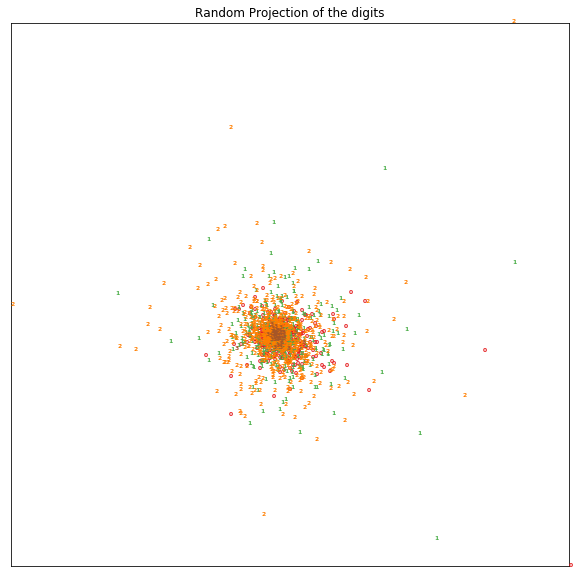

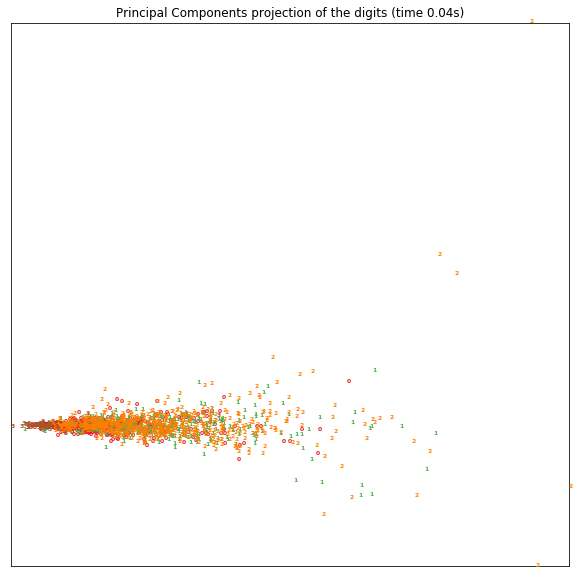

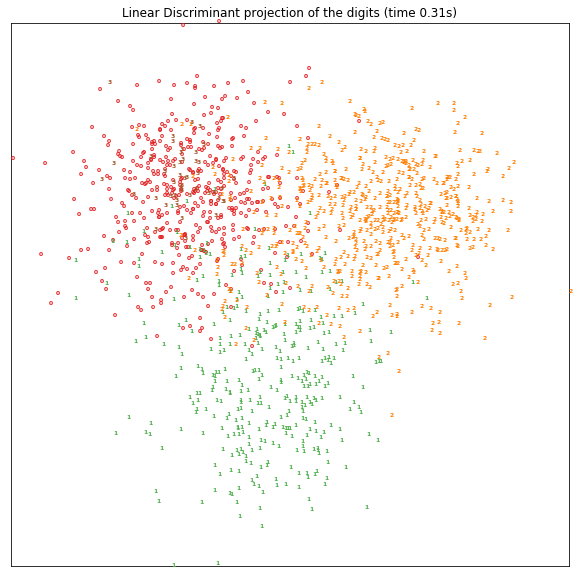

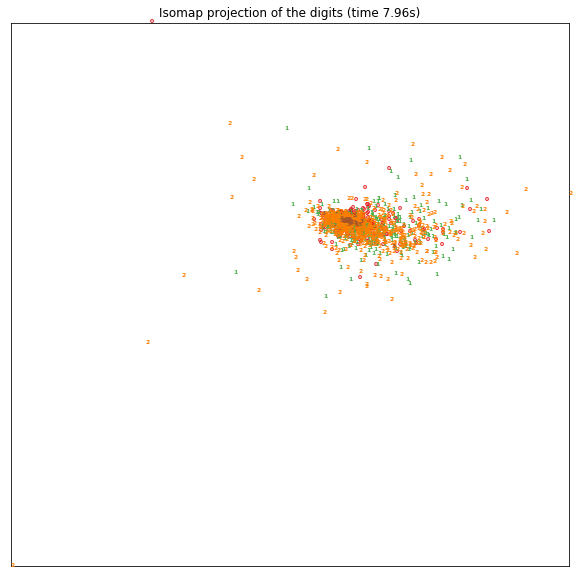

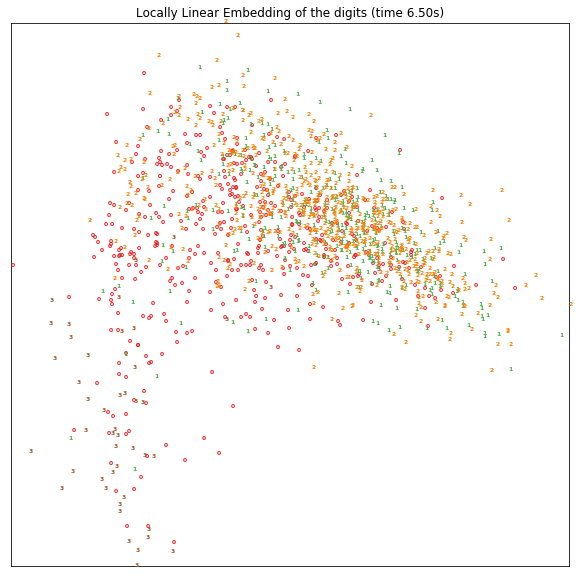

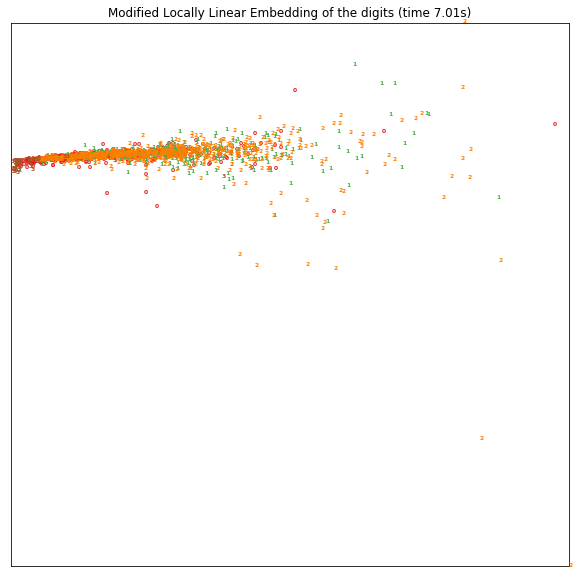

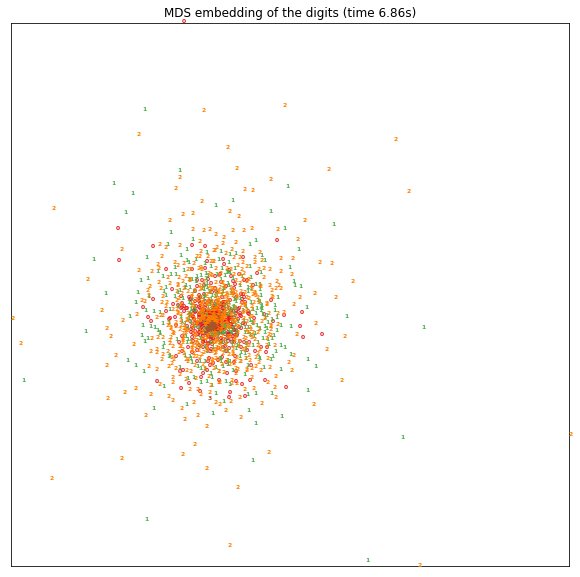

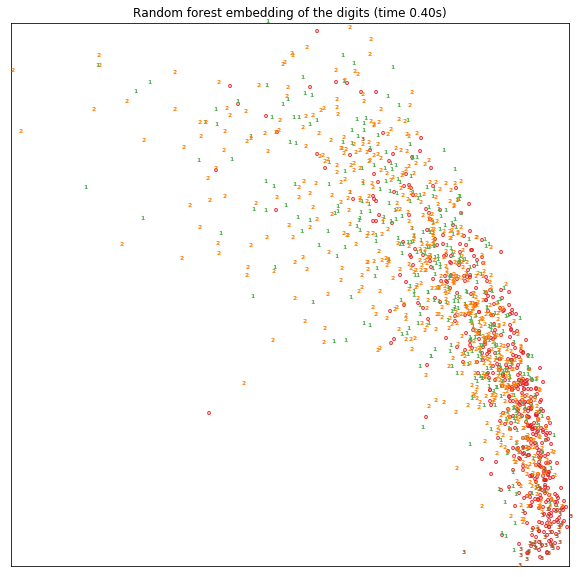

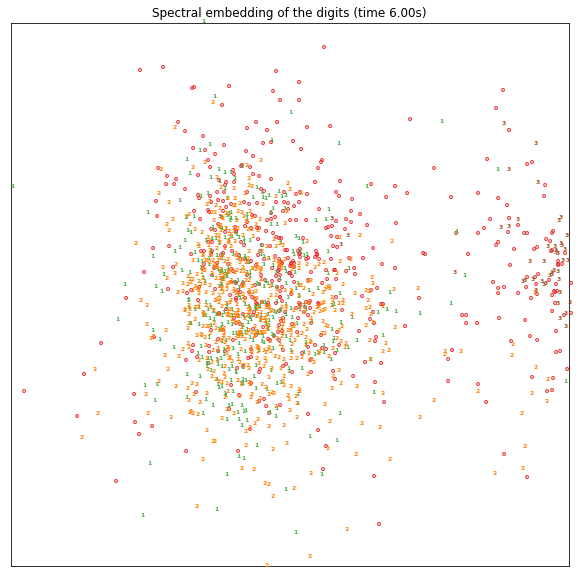

In [9]:
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection
from time import time
X = feature
y = label
n_samples, n_features = X.shape
n_neighbors = 30
#----------------------------------------------------------------------
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, y,"Random Projection of the digits")


#----------------------------------------------------------------------
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca, y,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# Projection on to the first 2 linear discriminant components

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
plot_embedding(X_lda, y,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# Isomap projection of the digits dataset
print("Computing Isomap embedding")
t0 = time()
X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
print("Done.")
plot_embedding(X_iso, y,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle, y,
               "Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# Modified Locally linear embedding of the digits dataset
print("Computing modified LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_mlle, y,
               "Modified Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))

'''
#----------------------------------------------------------------------
# HLLE embedding of the digits dataset
print("Computing Hessian LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='hessian')
t0 = time()
X_hlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_hlle,
               "Hessian Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))
'''
'''
#----------------------------------------------------------------------
# LTSA embedding of the digits dataset
print("Computing LTSA embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='ltsa')
t0 = time()
X_ltsa = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_ltsa,
               "Local Tangent Space Alignment of the digits (time %.2fs)" %
               (time() - t0))
'''

#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds, y,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# Random Trees embedding of the digits dataset
print("Computing Totally Random Trees embedding")
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
                                       max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced, y,
               "Random forest embedding of the digits (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# Spectral embedding of the digits dataset
print("Computing Spectral embedding")
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)

plot_embedding(X_se, y,
               "Spectral embedding of the digits (time %.2fs)" %
               (time() - t0))

-10.646816 198.41089


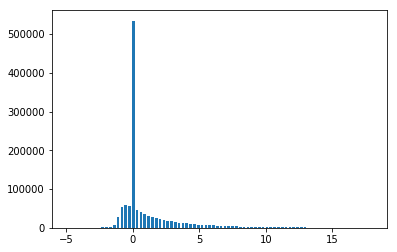

In [31]:
print(X.min(), X.max())
hist, bins = np.histogram(X, range=(-5, 18), bins=80)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()
print('zero elements:', np.count_nonzero(X==0))

0.9242174629324547 0.3560371517027864


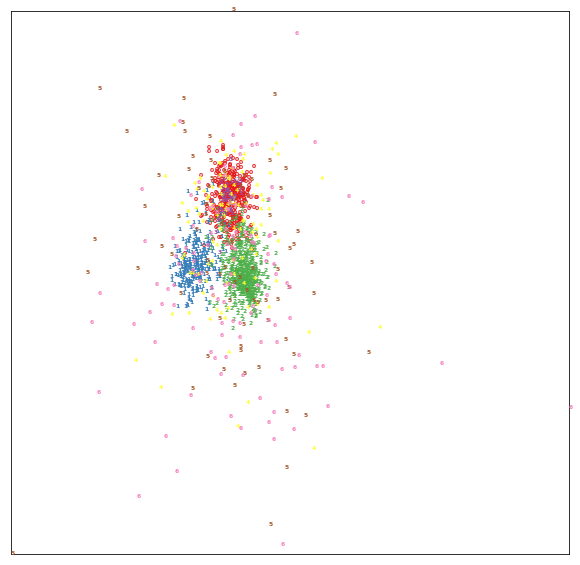

In [53]:
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

for _ in range(1):
    indicies_1, indicies_2 = random_sample(len(y), .8)
    X_t = [X[index, :] for index in indicies_1]
    y_t = [y[index] for index in indicies_1]
    X_v = [X[index, :] for index in indicies_2]
    y_v = [y[index] for index in indicies_2]
    
    # clf = svm.SVC(C=10, kernel='rbf', max_iter=-1)
    clf = LDA(n_components = 2)
    clf.fit(X_t, y_t)
    print(clf.score(X_t, y_t), clf.score(X_v, y_v))
    
    X_t = clf.transform(X_t)
    X_v = clf.transform(X_v)
    y_v = list(map(lambda x: x+4, y_v))
    
    plot_embedding(np.concatenate((X_t,X_v)), y_t+y_v)